## Imports

In [95]:
import pathlib
import PIL.Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import splitfolders
import os, shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Read Image Data

In [96]:
#Set data directory
data_dir = pathlib.Path('data-no-trash')

In [97]:
#show number of images included in directory
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2526


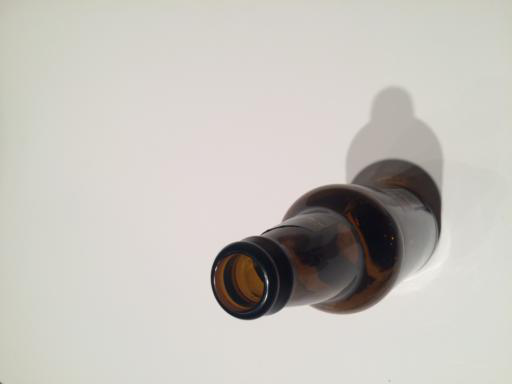

In [98]:
#Display a sample glass image
glass = list(data_dir.glob('glass/*'))
PIL.Image.open(str(glass[0]))

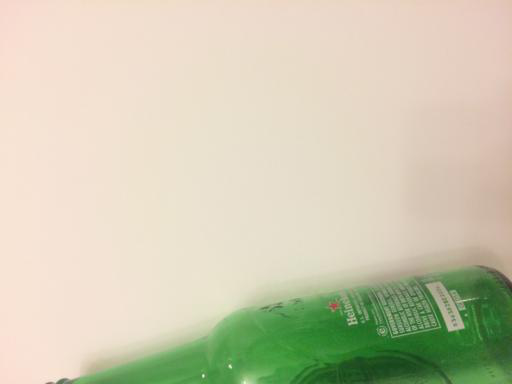

In [99]:
#Display another sample glass image
PIL.Image.open(str(glass[1]))

## Load Dataset

In [100]:
#Define some parameters for the loader:
batch_size = 32
img_height = 384
img_width = 512

#TODO: Resize to smaller size

In [101]:
# #clear images folder
folder = './images'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [102]:
def train_test_split_folders(data_dir):
    splitfolders.ratio(data_dir, output="images", seed=1337, ratio=(.8, 0.1,0.1))
    image_dir = 'images'

    #create training split  
    train_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/train',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    #create validation split
    val_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/val',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    #create validation split
    test_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/test',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = train_test_split_folders(data_dir=data_dir)

Found 2030 files belonging to 6 classes.
Found 252 files belonging to 6 classes.
Found 258 files belonging to 6 classes.


In [103]:
#Show names of the found classes
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'other', 'paper', 'plastic']


## Configure the dataset

*Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:*

    - Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
    
    - Dataset.prefetch overlaps data preprocessing and model execution while training.

*Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.*

## Standardize the data

In [104]:
# intializing rescaling layer to map onto data in the next step
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [105]:
# creating the normalized dataset
 
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in '[0, 1]'
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [106]:
AUTOTUNE = tf.data.AUTOTUNE

#load data into cache to reduce i/o
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [107]:
num_classes = len(class_names)

model = tf.keras.Sequential(
    [
    tf.keras.layers.Rescaling(1./255),
    
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes)
    ]
)

In [108]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [109]:
history = model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=15
)

Epoch 1/15
64/64 [==============================] - 10s 130ms/step - loss: 1.6174 - accuracy: 0.2734 - val_loss: 1.3301 - val_accuracy: 0.4603
Epoch 2/15
64/64 [==============================] - 8s 123ms/step - loss: 1.3098 - accuracy: 0.4409 - val_loss: 1.2189 - val_accuracy: 0.4802
Epoch 3/15
64/64 [==============================] - 8s 124ms/step - loss: 1.1650 - accuracy: 0.5271 - val_loss: 1.2281 - val_accuracy: 0.5000
Epoch 4/15
64/64 [==============================] - 8s 124ms/step - loss: 1.0491 - accuracy: 0.5778 - val_loss: 1.1670 - val_accuracy: 0.5794
Epoch 5/15
64/64 [==============================] - 8s 124ms/step - loss: 0.9186 - accuracy: 0.6340 - val_loss: 1.1623 - val_accuracy: 0.5635
Epoch 6/15
64/64 [==============================] - 8s 124ms/step - loss: 0.7514 - accuracy: 0.7167 - val_loss: 1.2034 - val_accuracy: 0.5754
Epoch 7/15
64/64 [==============================] - 8s 124ms/step - loss: 0.7105 - accuracy: 0.7335 - val_loss: 1.2056 - val_accuracy: 0.6032
Epoch

In [110]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 384, 512, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 384, 512, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 192, 256, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 192, 256, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 96, 128, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 96, 128, 32)      

In [111]:
#export training history
save = False

if save:
    np.save('test2_history.npy',history.history)

In [112]:
history = history.history

In [113]:
#import training history
load = False

if load:
    history=np.load('my_history.npy',allow_pickle='TRUE').item()

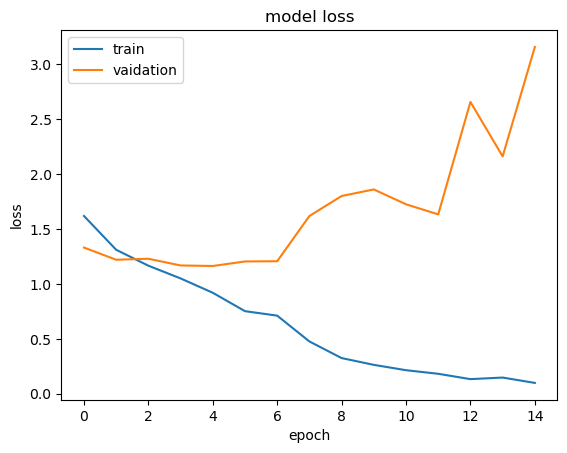

In [114]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vaidation'], loc='upper left')
plt.show()

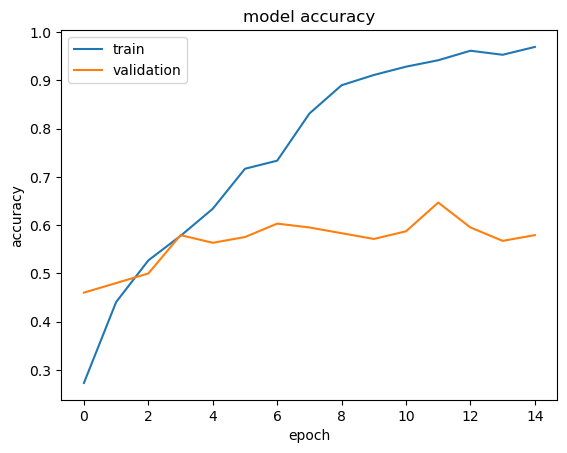

In [115]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [116]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [117]:
# i = 0
# plt.figure(figsize=(6,3))
# plt.subplot(1,2,1)
# plot_image(i, predictions[i], test_labels, test_images)
# plt.subplot(1,2,2)
# plot_value_array(i, predictions[i],  test_labels)
# plt.show()

In [118]:
# TODO: Tensorboard
# TODO: Predict Sample image
# TODO: Model Optimizer implementieren (KERAS Tuner)